## Generalized Autoregressive Conditional Heteroscedasticity models (GARCH)

In [ ]:
import pandas as pd
import numpy as np
import arch  # Import the arch library
import matplotlib.pyplot as plt

# Create an ARCH model
model = arch.arch_model(monthly_hdfc_data['returns'], vol='Garch', p=1, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10702.870996038777
Iteration:      2,   Func. Count:     15,   Neg. LLF: 97.26256097183254
Iteration:      3,   Func. Count:     24,   Neg. LLF: -81.95407757437036
Iteration:      4,   Func. Count:     29,   Neg. LLF: -65.38402774696151
Iteration:      5,   Func. Count:     35,   Neg. LLF: -82.05649657155965
Iteration:      6,   Func. Count:     40,   Neg. LLF: -82.05671061770178
Iteration:      7,   Func. Count:     45,   Neg. LLF: -82.05671265843029
Iteration:      8,   Func. Count:     49,   Neg. LLF: -82.05671257988695
Optimization terminated successfully    (Exit mode 0)
            Current function value: -82.05671265843029
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004859. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                82.0567
Distribution:                  Normal   AIC:                          -156.113
Method:            Maximum Likelihood   BIC:                          -147.478
                                        No. Observations:                   64
Date:                Wed, Oct 04 2023   Df Residuals:                       63
Time:                        20:12:07   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0180  8.060e-03      2.230  2.578e-02 [2.

In [ ]:
# Forecast volatility
forecast_horizon = 20  # Number of days to forecast
forecast = results.forecast(start=None, horizon=forecast_horizon)

# Extract the forecasted conditional variances
predicted_variances = forecast.variance.values[-1, :]

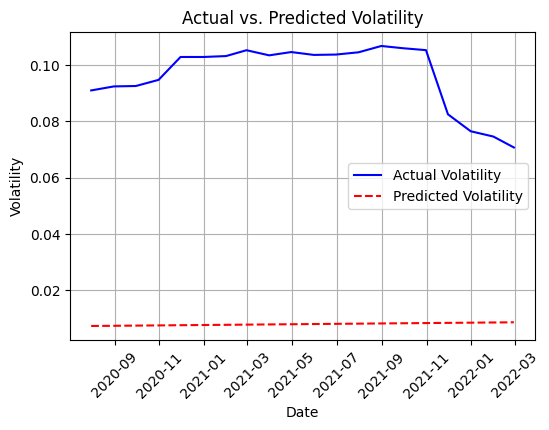

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'stock_data' contains the actual volatility and 'predicted_variances' contains the predicted volatility
plt.figure(figsize=(6, 4))
plt.plot(monthly_hdfc_data.index[-20:], monthly_hdfc_data['actual_volatility'].iloc[-20:], label='Actual Volatility', color='blue')
plt.plot(monthly_hdfc_data.index[-20:], predicted_variances, label='Predicted Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Actual vs. Predicted Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(monthly_hdfc_data['actual_volatility'].iloc[-20:], predicted_variances)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.00793369421517854


In [ ]:
import numpy as np

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.08907128726575439


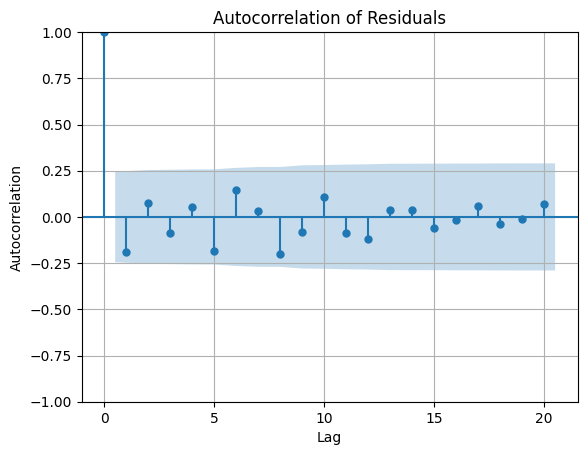

In [ ]:
import statsmodels.api as sm

# Get the residuals from the ARCH model
residuals = results.resid

# Assuming 'residuals' contains the model's residuals
sm.graphics.tsa.plot_acf(residuals, lags=20, title='Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=20)
# print("Ljung-Box Test p-values:", p_value)
print(lb_test['lb_pvalue'])
p_values = lb_test['lb_pvalue']

# Check p-values to determine if there is serial correlation
if any(p_values < 0.05):
    print("Serial correlation detected in residuals.")
else:
    print("No significant serial correlation in residuals.")


1     0.118005
2     0.241211
3     0.335711
4     0.463930
5     0.304560
6     0.275761
7     0.369760
8     0.219202
9     0.259567
10    0.275262
11    0.310392
12    0.309801
13    0.376038
14    0.444007
15    0.497878
16    0.569661
17    0.617594
18    0.674159
19    0.733404
20    0.758125
Name: lb_pvalue, dtype: float64
No significant serial correlation in residuals.


In [ ]:
arch_test = results.arch_lm_test()
print("ARCH Test Results:", arch_test)

ARCH Test Results: ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 12.2806
P-value: 0.3429
Distributed: chi2(11)


In [ ]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print("ARCH Test Results:", arch_test)

Mean Squared Error (MSE): 0.00793369421517854
Root Mean Squared Error (RMSE): 0.08907128726575439
ARCH Test Results: ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 12.2806
P-value: 0.3429
Distributed: chi2(11)


<ipython-input-131-fff440270b5b>:13: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  plt.plot(pd.date_range(start=monthly_hdfc_data.index[-1], periods=forecast_horizon + 1, closed='right'), forecasted_close_price, label='Forecasted Close Price', linestyle='--', color='green', linewidth=2)


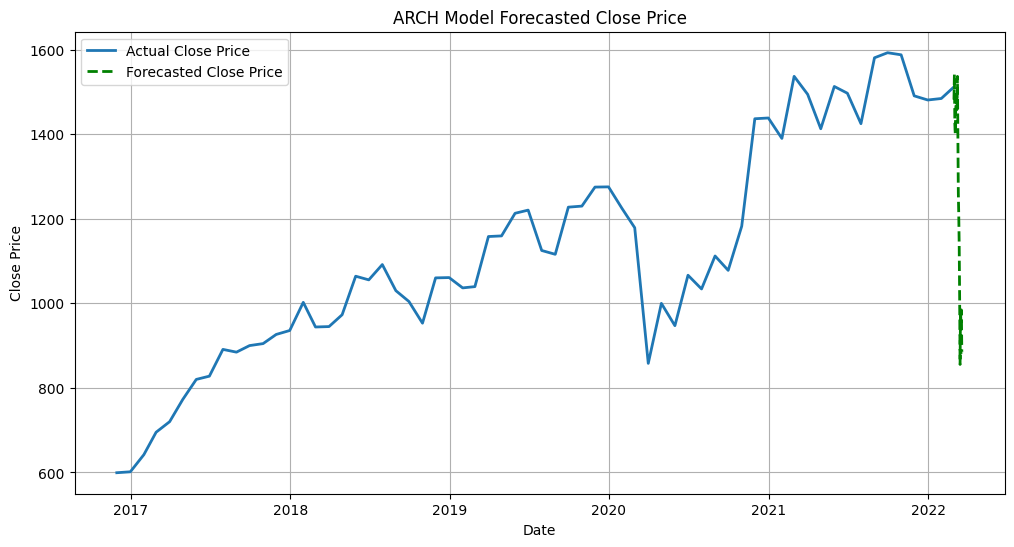

In [ ]:
# Get the last observed volatility
last_volatility = monthly_hdfc_data['returns'].rolling(window=20).std().dropna()

# Generate a simulated return series based on the forecasted volatility
simulated_returns = np.random.normal(scale=np.sqrt(forecast.variance.values[-1, :]), size=forecast_horizon)

# Calculate the forecasted close price
forecasted_close_price = monthly_hdfc_data['close'].iloc[-1] * np.exp(simulated_returns.cumsum())

# Plot the forecasted close price
plt.figure(figsize=(12, 6))
plt.plot(monthly_hdfc_data.index, monthly_hdfc_data['close'], label='Actual Close Price', linewidth=2)
plt.plot(pd.date_range(start=monthly_hdfc_data.index[-1], periods=forecast_horizon + 1, closed='right'), forecasted_close_price, label='Forecasted Close Price', linestyle='--', color='green', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARCH Model Forecasted Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import arch  # Import the arch library
import matplotlib.pyplot as plt

# Create an ARCH model
model = arch.arch_model(monthly_reliance_data['returns'], vol='Garch', p=1, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2312.291329702317
Iteration:      2,   Func. Count:     15,   Neg. LLF: 82.70793721518845
Iteration:      3,   Func. Count:     23,   Neg. LLF: 156.78842372941682
Iteration:      4,   Func. Count:     29,   Neg. LLF: -61.19539552918486
Iteration:      5,   Func. Count:     35,   Neg. LLF: -61.485385361641264
Iteration:      6,   Func. Count:     41,   Neg. LLF: -63.431327775455905
Iteration:      7,   Func. Count:     46,   Neg. LLF: -63.43160535028781
Iteration:      8,   Func. Count:     51,   Neg. LLF: -63.43160631158287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -63.43160631158287
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [ ]:
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                63.4316
Distribution:                  Normal   AIC:                          -118.863
Method:            Maximum Likelihood   BIC:                          -110.228
                                        No. Observations:                   64
Date:                Fri, Oct 06 2023   Df Residuals:                       63
Time:                        02:46:14   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0292  1.087e-02      2.689  7.161e-03 [7.

In [ ]:
# Forecast volatility
forecast_horizon = 20  # Number of days to forecast
forecast = results.forecast(start=None, horizon=forecast_horizon)

# Extract the forecasted conditional variances
v = forecast.variance.values[-1, :]

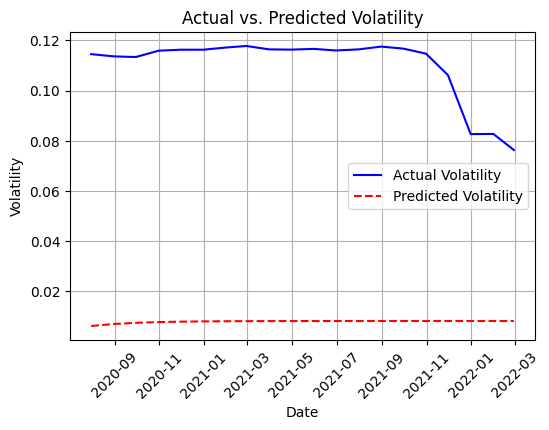

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'stock_data' contains the actual volatility and 'predicted_variances' contains the predicted volatility
plt.figure(figsize=(6, 4))
plt.plot(monthly_reliance_data.index[-20:], monthly_reliance_data['actual_volatility'].iloc[-20:], label='Actual Volatility', color='blue')
plt.plot(monthly_reliance_data.index[-20:], predicted_variances, label='Predicted Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Actual vs. Predicted Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(monthly_reliance_data['actual_volatility'].iloc[-20:], predicted_variances)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.010599091851132444


In [ ]:
import numpy as np

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.10295189095462232


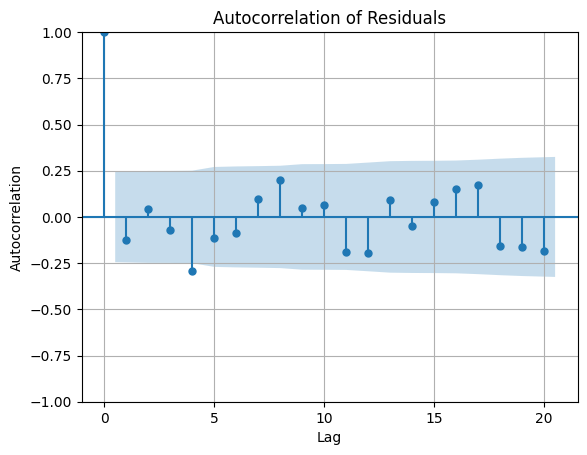

In [ ]:
import statsmodels.api as sm

# Get the residuals from the ARCH model
residuals = results.resid

# Assuming 'residuals' contains the model's residuals
sm.graphics.tsa.plot_acf(residuals, lags=20, title='Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=20)
# print("Ljung-Box Test p-values:", p_value)
print(lb_test['lb_pvalue'])
p_values = lb_test['lb_pvalue']

# Check p-values to determine if there is serial correlation
if any(p_values < 0.05):
    print("Serial correlation detected in residuals.")
else:
    print("No significant serial correlation in residuals.")


1     0.316975
2     0.569646
3     0.686937
4     0.107701
5     0.129338
6     0.168900
7     0.201198
8     0.118051
9     0.162978
10    0.207807
11    0.136676
12    0.085095
13    0.098672
14    0.128014
15    0.148711
16    0.122356
17    0.087767
18    0.069396
19    0.051957
20    0.031469
Name: lb_pvalue, dtype: float64
Serial correlation detected in residuals.


In [ ]:
arch_test = results.arch_lm_test()
print("ARCH Test Results:", arch_test)

ARCH Test Results: ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 13.3592
P-value: 0.2705
Distributed: chi2(11)


In [ ]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print("ARCH Test Results:", arch_test)

Mean Squared Error (MSE): 0.010599091851132444
Root Mean Squared Error (RMSE): 0.10295189095462232
ARCH Test Results: ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 13.3592
P-value: 0.2705
Distributed: chi2(11)


In [ ]:
import pandas as pd
import numpy as np
import arch  # Import the arch library
import matplotlib.pyplot as plt

# Create an ARCH model
model = arch.arch_model(monthly_sunpharma_data['returns'], vol='Garch', p=1, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 368.6600961683616
Iteration:      2,   Func. Count:     15,   Neg. LLF: 51.20198613790291
Iteration:      3,   Func. Count:     24,   Neg. LLF: -62.91546492839521
Iteration:      4,   Func. Count:     29,   Neg. LLF: -62.91548895165927
Iteration:      5,   Func. Count:     33,   Neg. LLF: -62.91548895158601
Optimization terminated successfully    (Exit mode 0)
            Current function value: -62.91548895165927
            Iterations: 5
            Function evaluations: 33
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008197. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [ ]:
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                62.9155
Distribution:                  Normal   AIC:                          -117.831
Method:            Maximum Likelihood   BIC:                          -109.195
                                        No. Observations:                   64
Date:                Fri, Oct 06 2023   Df Residuals:                       63
Time:                        02:47:13   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.2614e-03  1.704e-02      0.367      0.713 

In [ ]:
# Forecast volatility
forecast_horizon = 20  # Number of days to forecast
forecast = results.forecast(start=None, horizon=forecast_horizon)

# Extract the forecasted conditional variances
predicted_variances = forecast.variance.values[-1, :]

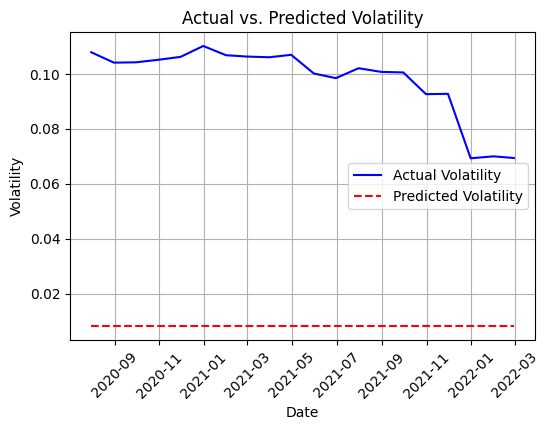

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'stock_data' contains the actual volatility and 'predicted_variances' contains the predicted volatility
plt.figure(figsize=(6, 4))
plt.plot(monthly_sunpharma_data.index[-20:], monthly_sunpharma_data['actual_volatility'].iloc[-20:], label='Actual Volatility', color='blue')
plt.plot(monthly_sunpharma_data.index[-20:], predicted_variances, label='Predicted Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Actual vs. Predicted Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(monthly_sunpharma_data['actual_volatility'].iloc[-20:], predicted_variances)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.008210464732815306


In [ ]:
import numpy as np

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.090611614778765


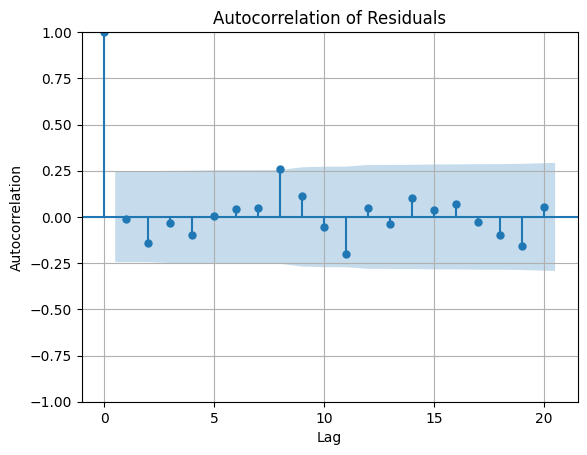

In [ ]:
import statsmodels.api as sm

# Get the residuals from the ARCH model
residuals = results.resid

# Assuming 'residuals' contains the model's residuals
sm.graphics.tsa.plot_acf(residuals, lags=20, title='Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=20)
# print("Ljung-Box Test p-values:", p_value)
print(lb_test['lb_pvalue'])
p_values = lb_test['lb_pvalue']

# Check p-values to determine if there is serial correlation
if any(p_values < 0.05):
    print("Serial correlation detected in residuals.")
else:
    print("No significant serial correlation in residuals.")


1     0.918986
2     0.501254
3     0.692585
4     0.714549
5     0.832573
6     0.894419
7     0.933466
8     0.484858
9     0.482807
10    0.554610
11    0.371420
12    0.439254
13    0.511617
14    0.518251
15    0.584832
16    0.622346
17    0.684883
18    0.689739
19    0.599180
20    0.642702
Name: lb_pvalue, dtype: float64
No significant serial correlation in residuals.


In [ ]:
arch_test = results.arch_lm_test()
print("ARCH Test Results:", arch_test)

ARCH Test Results: ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 2.9220
P-value: 0.9917
Distributed: chi2(11)


In [ ]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print("ARCH Test Results:", arch_test)

Mean Squared Error (MSE): 0.008210464732815306
Root Mean Squared Error (RMSE): 0.090611614778765
ARCH Test Results: ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 2.9220
P-value: 0.9917
Distributed: chi2(11)
